# Long & Short direction mean reversion strategy with Bollinger Bands, Uniswap v3 on Polygon

This strategy introduces the new shorting capabilities of the TradingStrategy framework. Shorting allows us to profit on downturns in the market, so now, if we trade correctly, it is possible to earn profit whether the market is going up or down.

### Shorting

For those of you who aren't familiar with shorting, here is a quick explanation: 

Short selling, often referred to as "shorting," is an investment strategy where an investor borrows shares of a stock or other asset that they believe will decrease in value by a set future date. The investor sells these borrowed shares to buyers willing to pay the current market price. Later, the investor aims to buy back the shares at a lower price.

However, short selling comes with significant risks. If the stock price increases instead of decreasing, the investor will have to buy back the shares at a higher price, leading to a loss. This loss can be substantial, as theoretically, a stock's price can rise indefinitely. That's why is important to always use a stop loss with shorting.

Short selling is often used as a way to hedge against the downside risk of a long position in the same or similar stocks. It can also be used by those who believe the market or a particular stock is overvalued and due for a downturn.

### Leverage

Leverage refers to the use of various financial instruments or borrowed capital (like debt) to increase the potential return of an investment. It allows investors to increase their market exposure beyond what would be possible with their own capital alone. Basically, leverage amplifies investment power; however, leverage also amplifies losses if the investment does not perform as expected. Since the investor must repay the borrowed funds regardless of the investment's success, losses can exceed the initial amount of capital. So again, remember your stop losses!

## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters


In [1]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.lending import LendingProtocolType  # NEW
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency

# Tell what trade execution engine version this strategy needs to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE_ENGINE_VERSION = "0.1"

# What kind of strategy we are running.
# This tells we are going to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE = StrategyType.managed_positions

# How our trades are routed.
TRADE_ROUTING = TradeRouting.uniswap_v3_usdc

# How often the strategy performs the decide_trades cycle.
# We do it for every 4h.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_4h

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.h4

# Which trading pair we are backtesting on
TRADING_PAIR = (ChainId.polygon, "uniswap-v3", "WETH", "USDC", 0.0005)

# Which lending reserves we are using for supplying/borrowing assets
# NEW
LENDING_RESERVES = [
    (ChainId.polygon, LendingProtocolType.aave_v3, "WETH"),
    (ChainId.polygon, LendingProtocolType.aave_v3, "USDC"),
]

# How much % of the cash to put on a single trade
POSITION_SIZE = 0.8

# Start with this amount of USD
INITIAL_DEPOSIT = 50_000

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.h1

#
# Strategy thinking specific parameter
#

# How many candles we load in the decide_trades() function for calculating indicators
LOOKBACK_WINDOW = 50

# Moving average 
# How many candles to smooth out for Bollinger band's middle line
EMA_CANDLE_COUNT = 20  


# How many candles we use to calculate the Relative Strength Indicator
RSI_LENGTH = 14

# RSI must be above this value to open a new Long position
RSI_THRESHOLD = 35

# RSI must be above this value to open a new Short position
RSI_THRESHOLD_SHORT = 70

# Backtest time range: start date
START_AT = datetime.datetime(2022, 7, 20)

# Backtest time range: end date
END_AT = datetime.datetime(2023, 9, 27)


# A fixed Stop Loss for Long positions relative to the mid price during the time when the position is opened
# If the price candle closes below this level in a Long position, stop loss gets triggered
STOP_LOSS_PCT = 0.97

# A fixed Stop Loss for Short positions relative to the mid price during the time when the position is opened
# If the price candle closes above this level in a Short position, stop loss gets triggered
STOP_LOSS_SHORT_PCT = 0.97

# Take profit percentage for Long positions
TAKE_PROFIT_PCT = 1.035

# Take profit percentage for Short positions
TAKE_PROFIT_SHORT_PCT = 1.035

# Leverage ratio for short positions. We use leverage that is hogher than 1, because lending pools require more collateral than the amount that you want to borrow
LEVERAGE = 2


## Strategy logic and trade decisions

In this example, we calculate two exponential moving averages
(EMAs) and make decisions based on those:

- enter Long positions when price candle closes below the lower BB line
- enter Short position when price candle closes above the higher BB line
- use RSI value as threshold and additional confluence when deciding trade entries
- 4 hour price candle time frame for price action analysis and trade entries
- use a fixed % based stop loss with 1 hour price candle time frame
- enable Short positions by using Aave v3 lending pools for borrowing the token that you want to short sell

### Indicators

- Note how we also make use of detached and overlayed technical indicators, so that the price chart is not overcrowded


In [2]:
from typing import List, Dict

from pandas_ta import bbands
from pandas_ta.overlap import ema
from pandas_ta.momentum import rsi

from tradingstrategy.universe import Universe
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse

from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager


def decide_trades(
        timestamp: pd.Timestamp,
        strategy_universe: TradingStrategyUniverse,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
  
    universe = strategy_universe.universe

    # We have only a single trading pair for this strategy.
    pair = universe.pairs.get_single()

    # How much cash we have in a hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=LOOKBACK_WINDOW)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close_prices = candles["close"]

    # Calculate exponential moving for candle close
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/overlap/help/pandas_ta.overlap.ema.html#ema
    moving_average = ema(close_prices, length=EMA_CANDLE_COUNT)
    
    
    # Calculate RSI for candle close
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/momentum/help/pandas_ta.momentum.rsi.html#rsi
    current_rsi = rsi(close_prices, length=RSI_LENGTH)[-1]

    trades = []

    if moving_average is None:
        # Cannot calculate EMA, in case there are not enough data points in backtesting buffer yet.
        return trades


    # Price at the most recent candle close
    price_close = close_prices.iloc[-1]

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, strategy_universe, state, pricing_model)



    # Calculate wider Bollinger Bands using the typical 20-day MA and 2 standard deviations 
    bollinger_bands_wide = bbands(close_prices, length=20, std=2)
    wide_bb_upper = bollinger_bands_wide["BBU_20_2.0"]
    wide_bb_lower = bollinger_bands_wide["BBL_20_2.0"]
    
    ### LONGING
    if not position_manager.is_any_long_position_open():
        # We open long if the latest candle close is under the lower BB line, the previous candle close was above the lower BB line, and RSI is above the RSI threshold value
        if price_close < wide_bb_lower.iloc[-1] and candles["open"].iloc[-1] > wide_bb_lower.iloc[-1] and close_prices.iloc[-2] > wide_bb_lower.iloc[-2] and current_rsi > RSI_THRESHOLD:
            amount = cash * POSITION_SIZE
            new_trades = position_manager.open_1x_long(pair, amount, stop_loss_pct=STOP_LOSS_PCT, take_profit_pct=TAKE_PROFIT_PCT)
            trades.extend(new_trades)
    else:
        # LONGING: We close the position when the price closes above the moving average line.
        if price_close > moving_average.iloc[-1] and close_prices.iloc[-2] < moving_average.iloc[-2]:
            current_position = position_manager.get_current_long_position()
            new_trades = position_manager.close_position(current_position)
            trades.extend(new_trades)
    
    ### SHORTING
    if not position_manager.is_any_short_position_open():
        # We open Short position if the latest candle close is above the higher BB line, the previous candle close was below the higher BB line, and RSI is below the RSI threshold value
        if price_close > wide_bb_upper.iloc[-1] and close_prices.iloc[-2] < wide_bb_upper.iloc[-2] and current_rsi < RSI_THRESHOLD_SHORT:
            amount = cash * POSITION_SIZE
            new_trades = position_manager.open_short(pair, amount, leverage=LEVERAGE, stop_loss_pct=STOP_LOSS_SHORT_PCT, take_profit_pct=TAKE_PROFIT_SHORT_PCT)
            trades.extend(new_trades)
    else:
        # We close the position when the price closes below the moving average line.
        if price_close < moving_average.iloc[-1] and close_prices.iloc[-2] > moving_average.iloc[-2]:
            current_position = position_manager.get_current_short_position()
            new_trades = position_manager.close_position(current_position)
            trades.extend(new_trades)
        
    # Visualise our technical indicators
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "Wide BB upper", PlotKind.technical_indicator_on_price, wide_bb_upper.iloc[-1], colour="red")
    visualisation.plot_indicator(timestamp, "Wide BB lower", PlotKind.technical_indicator_on_price, wide_bb_lower.iloc[-1], colour="red")
    visualisation.plot_indicator(timestamp, "EMA", PlotKind.technical_indicator_on_price, moving_average.iloc[-1], colour="black")
    visualisation.plot_indicator(timestamp, "RSI", PlotKind.technical_indicator_detached, current_rsi)

    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, single exchange and a single trading pair.

Trading Strategy framework supports complex strategies, spanning thousands of pairs and lending pools,
but we are not interested in this example.

In [3]:
import datetime
from tradingstrategy.client import Client
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    dataset = load_partial_data(
        client,
        execution_context=execution_context,
        time_bucket=CANDLE_TIME_BUCKET,
        pairs=[TRADING_PAIR],
        universe_options=universe_options,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        lending_reserves=LENDING_RESERVES,  # NEW
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Filter down to the single pair we are interested in
    strategy_universe = TradingStrategyUniverse.create_single_pair_universe(dataset)

    return strategy_universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [4]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/alex/.tradingstrategy


## Load data

In [5]:
from datetime import timedelta
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions(
        # NOTE: quick hack to get enough data for look back period
        start_at=START_AT - timedelta(days=50),
        end_at=END_AT,
    )
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

We loaded 2,681 candles.


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.


In [6]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="BB short example",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    engine_version="0.3",
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/37497600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 136 trades


## Examine backtest results

Examine `state` that contains all actions the trade executor took.

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [7]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 68
Trades made: 136


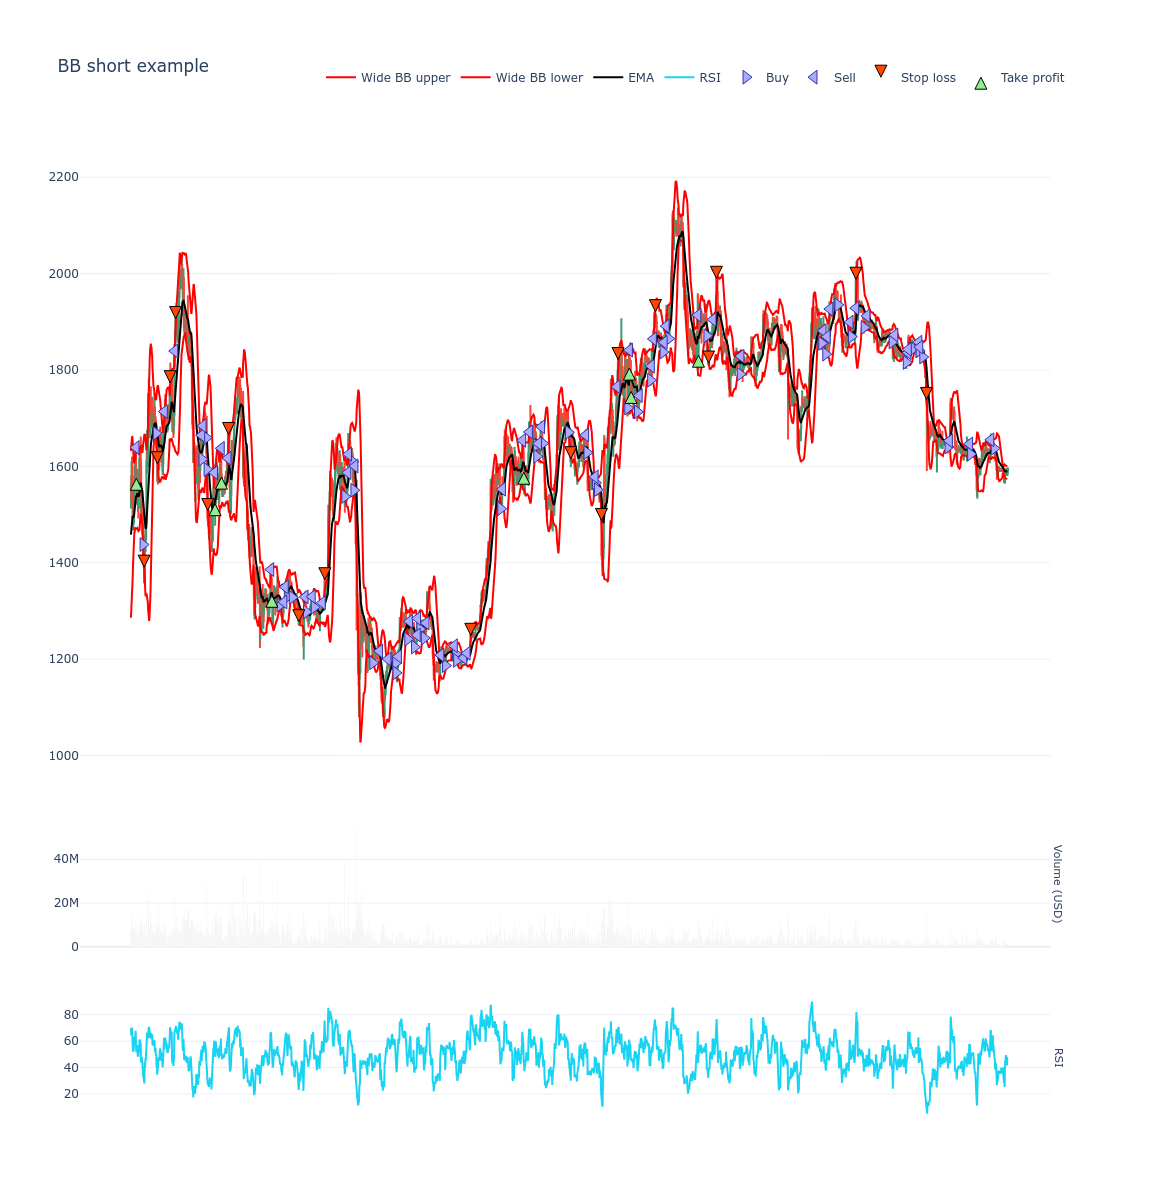

In [8]:

from tradeexecutor.visual.single_pair import visualise_single_pair, visualise_single_pair_positions_with_duration_and_slippage
from tradingstrategy.charting.candle_chart import VolumeBarMode

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=START_AT,
    end_at=END_AT,
    volume_bar_mode=VolumeBarMode.separate,
    volume_axis_name="Volume (USD)",
    height = 1200,
)

figure.show()

/tmp/ipykernel_61373/746198727.py:1: DeprecationWarning:

This module is deprecated. Import tradeexecutor.utils.notebook instead



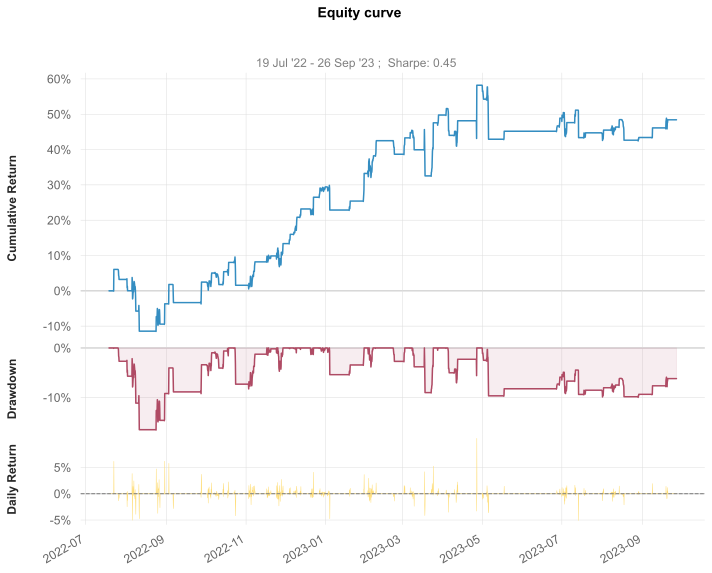

In [9]:
from tradeexecutor.backtest.notebook import setup_charting_and_output
setup_charting_and_output()


# Needed to improve the resolution of matplotlib chart used here
%config InlineBackend.figure_format = 'svg'

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold the underlying trading pair base asset


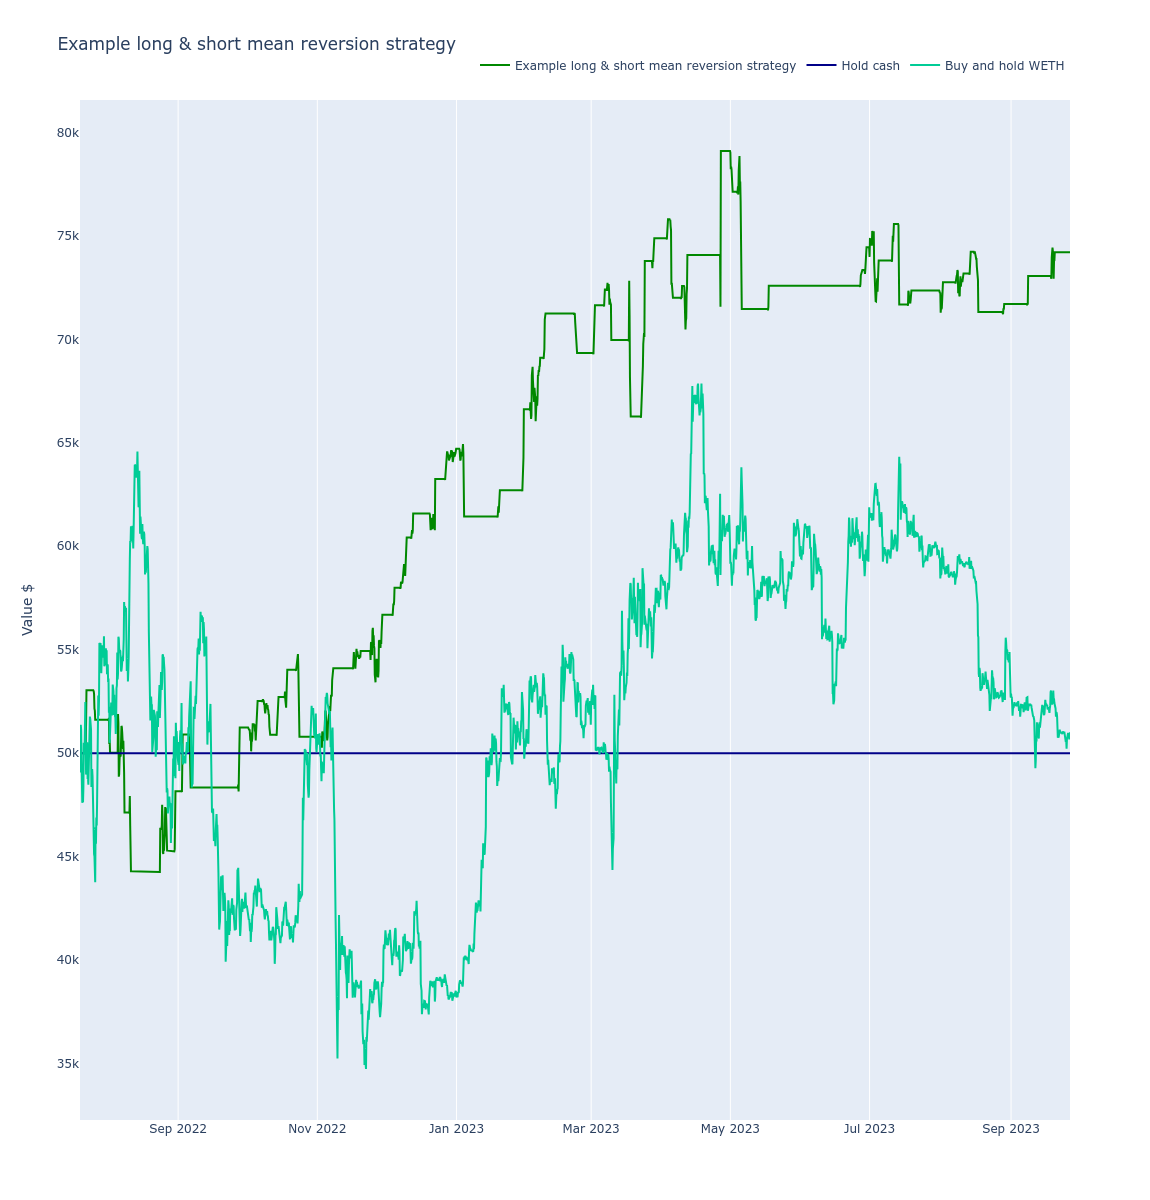

In [10]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    "Example long & short mean reversion strategy",
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=1200
)

fig.show()

## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [11]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Strategy summary

Overview of strategy performance



In [12]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics(state=state, time_bucket = CANDLE_TIME_BUCKET)

# with pd.option_context("display.max_row", None):
#      display(summary.to_dataframe())

summary.display()

In [13]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
display(format_multipair_summary(multipair_summary))

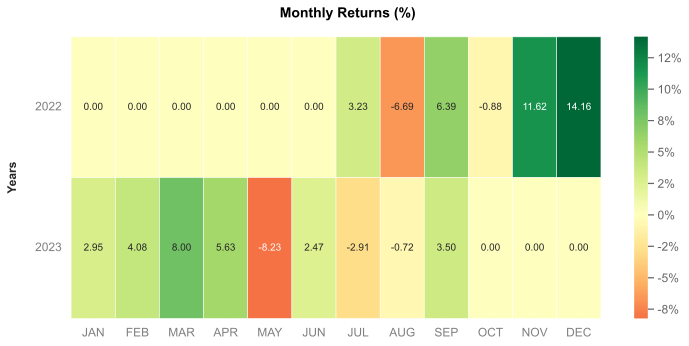

In [14]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

In [15]:
from IPython.core.display_functions import display

summary = analysis.calculate_all_summary_stats_by_side(state=state, time_bucket=CANDLE_TIME_BUCKET)

with pd.option_context("display.max_row", None):
    display(summary)

In [16]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

with pd.option_context("display.max_row", None):
    display(metrics)

Strategy
Start Period               2022-07-20
End Period                 2023-09-26
Risk-Free Rate                   0.0%
Time in Market                  22.0%
Cumulative Return              48.43%
CAGR﹪                           39.5%
Sharpe                           0.55
Prob. Sharpe Ratio             93.46%
Smart Sharpe                     0.51
Sortino                          0.86
Smart Sortino                     0.8
Sortino/√2                       0.61
Smart Sortino/√2                 0.57
Omega                            1.25
Max Drawdown                  -16.56%
Longest DD Days                   148
Volatility (ann.)              11.26%
Calmar                           2.39
Skew                             2.76
Kurtosis                        72.57
Expected Daily                  0.02%
Expected Monthly                2.67%
Expected Yearly                21.83%
Kelly Criterion                 9.72%
Risk of Ruin                     0.0%
Daily Value-at-Risk            -0.95%
Expected Shortfall (cVaR)      -0.95%
Max Consecutive Wins                8
Max Consecutive Losses              6
Gain/Pain Ratio                  0.42
Gain/Pain (1M)                   2.42
Payoff Ratio                     1.29
Profit Factor                    1.25
Common Sense Ratio               1.92
CPC Index                        0.79
Tail Ratio                       1.54
Outlier Win Ratio               18.49
Outlier Loss Ratio               2.78
MTD                              3.5%
3M                              2.23%
6M                              0.58%
YTD                            14.68%
1Y                             53.54%
3Y (ann.)                       39.5%
5Y (ann.)                       39.5%
10Y (ann.)                      39.5%
All-time (ann.)                 39.5%
Best Day                       10.52%
Worst Day                      -5.07%
Best Month                     14.16%
Worst Month                    -8.23%
Best Year                      29.42%
Worst Year                     14.68%
Avg. Drawdown                  -2.25%
Avg. Drawdown Days                  9
Recovery Factor                  2.92
Ulcer Index                      0.07
Serenity Index                   0.35
Avg. Up Month                    6.2%
Avg. Down Month                -3.89%
Win Days                       49.09%
Win Month                      66.67%
Win Quarter                     60.0%
Win Year                       100.0%

### Position and trade timeline

Display all positions and how much profit they made.

In [17]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [18]:
print("All ok")

All ok
